In [2]:
# Code for: <Add description here>
%load_ext autoreload
%autoreload 2
import cmcrameri.cm as cm  # Importing the cmcrameri colormaps
#%run ct_data.py '../crunchtope_model/results.nc' -c volume
%run pf_data.py '../pflotran_model/hydrothermal.nc'

Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Epidote', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Epidote', 'Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}


In [3]:
#Parameters
time = 1000

In [11]:
# Code for: <Add description here>
import matplotlib.pyplot as plt
from itertools import cycle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Define a function for a custom color cycler
def custom_color_cycler():
   # Define a function for a custom Futurist-inspired color cycler
    colors = {
        'Magnesium': '#3498DB',   # Dark steel blue, dignified and cool
        'Sulfate': '#F1C40F',     # Dark, bold red with a lot of presence
        'Calcium': '#2ECC71',     # Dark jade green, distinct and elegant
        'Carbonate': '#E74C3C'    # Dark amethyst, standing apart with a creative, luxurious tone
    }
    
    # Create a color cycle
    return cycle([colors['Magnesium'], colors['Sulfate'], colors['Calcium'], colors['Carbonate']])


def plot_flux(ax, inset_ax, concentrations, data, plot_var,range_sets, legend_entries, crunchtope=False, linestyle='-'):
    """
    plot_flux: <Add description of function>
    """
    if crunchtope:
        dims = ['X', 'Y', 'Z']
    else:
        dims = ['x', 'y', 'z']
    
    custom_cycler = custom_color_cycler()

    for conc_range, range_set, legend_entry in zip(concentrations, range_sets, legend_entries):
        # Processing data
        extracted_data = data[plot_var].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)).mean(dim=dims)
        if plot_var == 'Anhydrite_VF':
            # Scale up by volume
            extracted_data = data[plot_var].sel(time=time).isel(file_number=slice(range_set[0], range_set[1] + 1)).sum(dim=dims)
            volume = extracted_data.to_numpy() * 46.9 * 46.9 * 100 # m^3
            moles = volume_to_moles(volume, molar_volume)
            flux = moles / time * 65000e3 / 100 / 1e12 # tmol/yr
            extracted_data = flux
        
        if legend_entry == 'HCO$\mathbf{_3^-}$':
            color = next(custom_cycler)
            inset_ax.plot(conc_range, extracted_data, label=legend_entry, color=color, linestyle=linestyle)
            ax.plot([], [], label=legend_entry, color=color, linestyle=linestyle)
        else:
            ax.plot(conc_range, extracted_data, label=legend_entry, color=next(custom_cycler), linestyle=linestyle)
        print(f'For {legend_entry}, the values are {extracted_data}')

In [17]:
def anhydrite_depth(data):
    import xarray as xr
    # First, create a DataArray for depth, assuming `y` represents depth below seafloor
    depth = 1500 - data['z']

    mineral_data = data['Anhydrite_VF'].sel(time=time)
    # Expand depth to match the shape of the DataArray (`depth` has one dimension while `mineral_data` has two)

    weighted_depth = data['Temperature'].sel(time=time) * mineral_data

    # Sum the weighted depth and the total mineral amount
    total_weighted_depth = weighted_depth.sum(dim=('x', 'y', 'z'))
    total_mineral_amount = mineral_data.sum(dim=('x', 'y', 'z'))

    # Calculate the average depth weighted by the amount of mineral
    average_depth = total_weighted_depth / total_mineral_amount

    # Extract the average value (as it may return a DataArray)
    average_depth_value = average_depth.to_numpy()

    return average_depth_value

In [18]:
# Code for: <Add description here>

def total_volume(data, mineral):
    """
    total_volume: <Add description of function>
    """
    # Sum variables over all coordinates and select the final time 
    total_vf = data.sum(dim=('x','y','z')).sel(time=time)[mineral].to_numpy()
    total_volume = total_vf * 46.9 * 46.9 * 100 # m^3 

    return total_volume

def volume_to_moles(volume, molar_volume):
    """
    volume_to_moles: <Add description of function>
    """
    moles = volume / molar_volume
    return moles

molar_volume = 46.01 * (0.01 ** 3) # cm3/mol

vol = total_volume(pf_data, "Anhydrite_VF")
moles = volume_to_moles(vol, molar_volume)
flux = moles / time *65000e3 /100 /1e12
#s_moles_to_flux(moles) / 100

For SO$\mathbf{_4^{2-}}$, the values are [0.03814656 0.13519814 0.22165878 0.28798424 0.38101966]
For HCO$\mathbf{_3^-}$, the values are [0.2880507  0.28782794 0.28760396 0.28737739 0.28714827]
For Ca$\mathbf{^{2+}}$, the values are [0.28798424 0.32887082 0.36398828 0.36872505]
For Mg$\mathbf{^{2+}}$, the values are [0.28355156 0.28472796 0.28606626 0.28714127 0.28798424 0.28819807]


/tmp/ipykernel_219573/3358918669.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_219573/3358918669.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


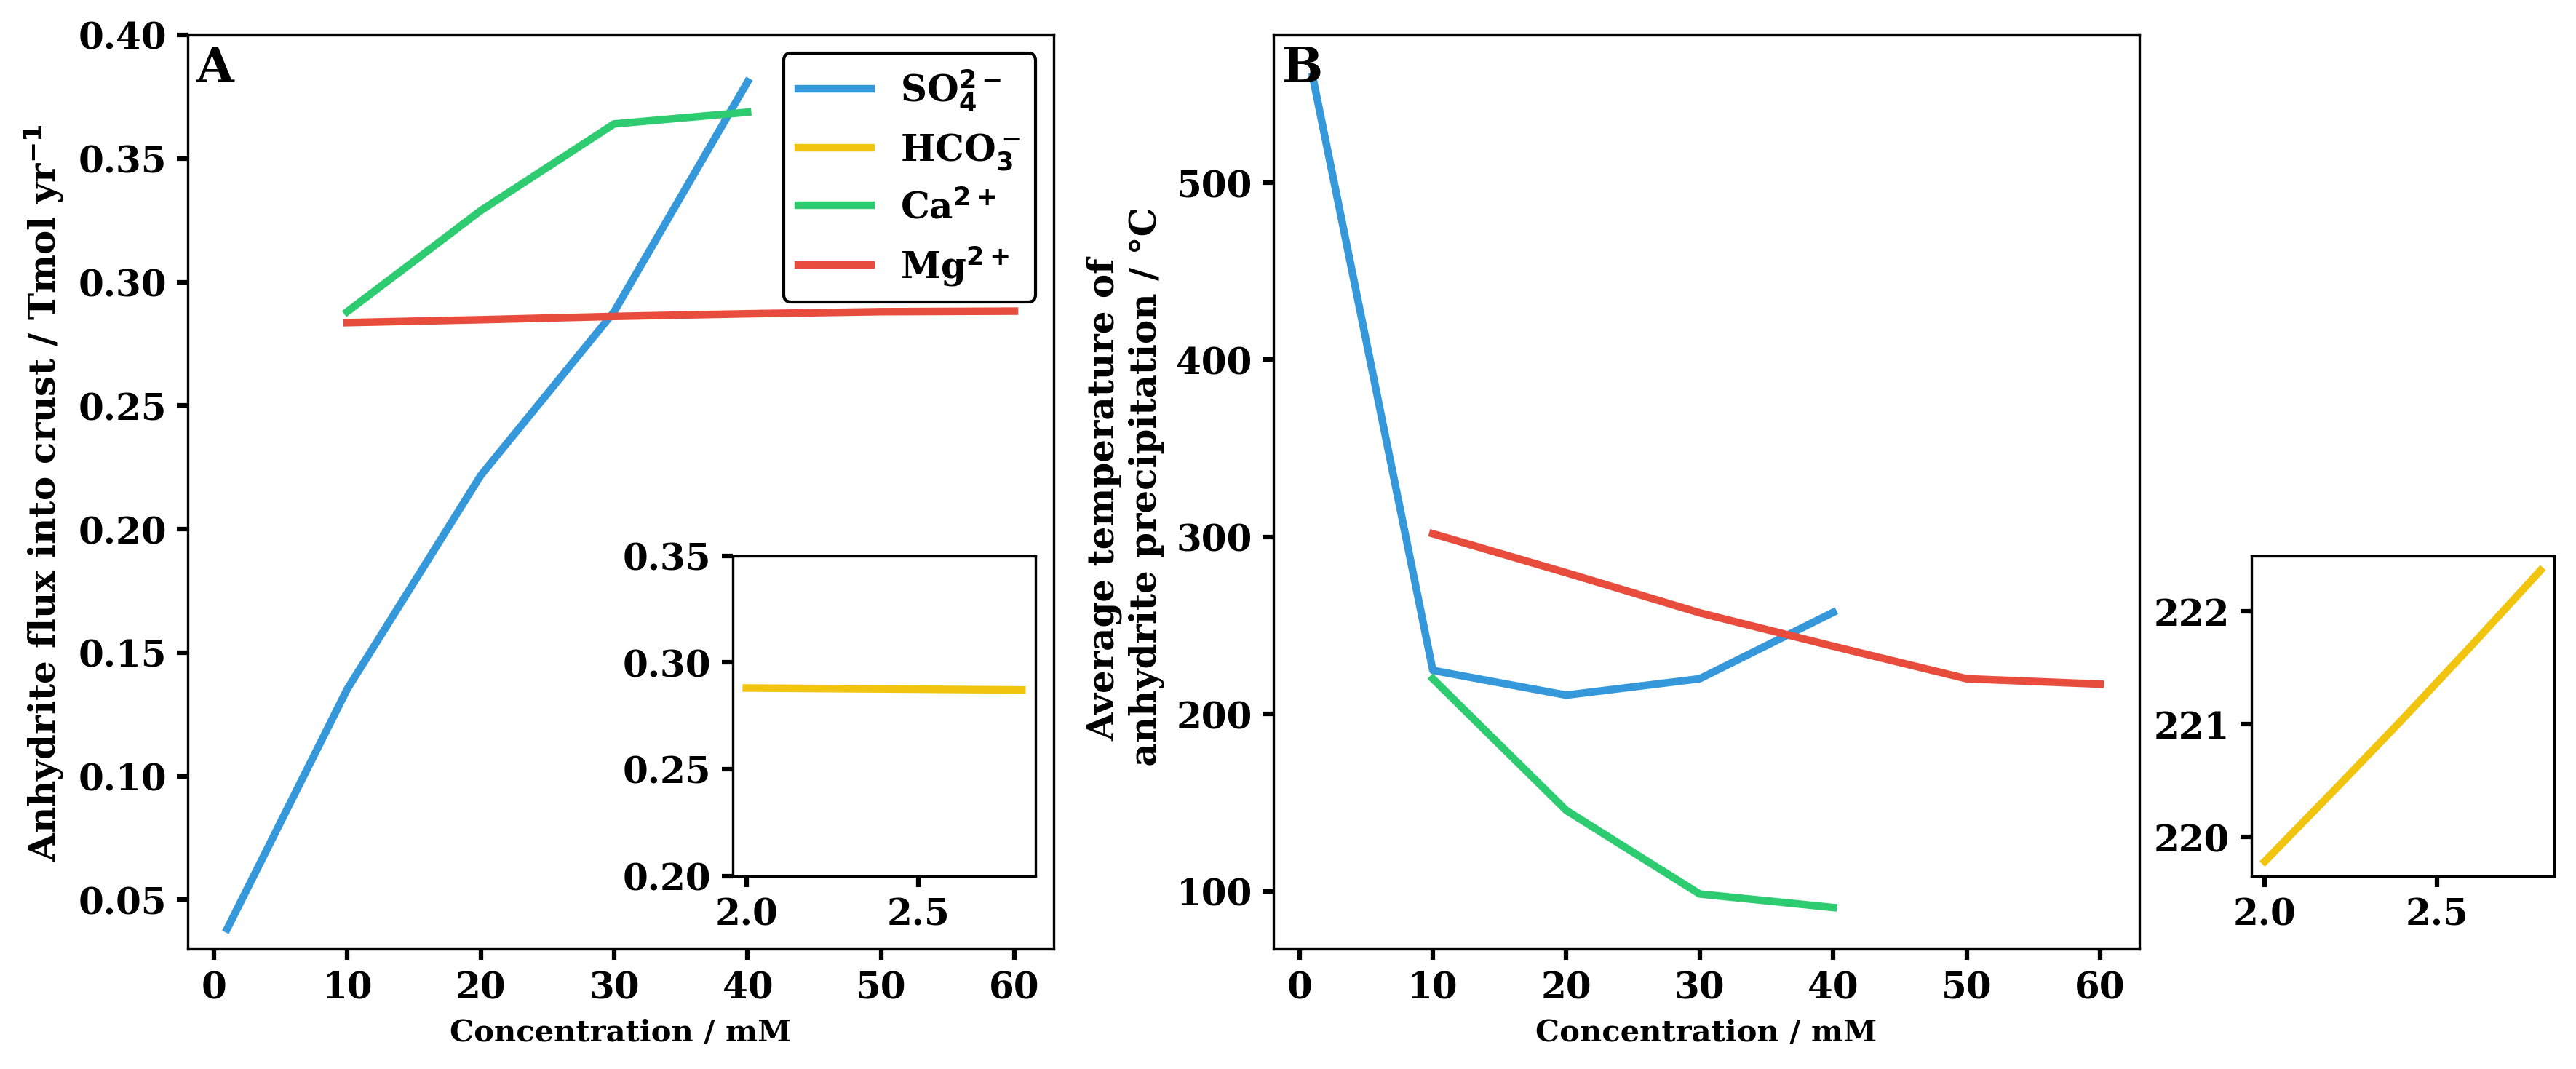

In [40]:
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('custom.mplstyle')
from cmcrameri import cm
import numpy as np
import copy
import string


# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flatten()

fontsize = fig.bbox_inches.width * 1.2

# Add capital letter labels to the subplots
for i, axis in enumerate(ax):
    axis.text(0.01, 0.99, string.ascii_uppercase[i], transform=axis.transAxes,
              fontsize=16, fontweight='bold', va='top')

# Example data and parameters
leg_entries = ['SO$\mathbf{_4^{2-}}$', 'HCO$\mathbf{_3^-}$', 'Ca$\mathbf{^{2+}}$', 'Mg$\mathbf{^{2+}}$']
range_sets = [(10, 14), (15, 19), (6, 9), (0, 5)]
concentrations = [[1, 10, 20, 30, 40],  # SO4
                  [2.0, 2.2, 2.4, 2.6, 2.8],  # HCO3
                  [10, 20, 30, 40],  # Ca
                  [10, 20, 30, 40, 50, 60]]  # Mg

# create an inset for ax[0]
inset_ax = inset_axes(ax[0],
                    width="70%", # width = 30% of parent_bbox
                    height="70%", # height : 1 inch
                    bbox_to_anchor=(0.5, -0.05, 0.5, 0.5),
                    bbox_transform=ax[0].transAxes)

# create an inset for ax[1]
inset_ax2 = inset_axes(ax[1],
                    width="70%", # width = 30% of parent_bbox
                    height="70%", # height : 1 inch
                    bbox_to_anchor=(0.5, -0.05, 0.5, 0.5),
                    bbox_transform=ax[1].transAxes)

# Plot flux (dummy function for example)
plot_var = 'Anhydrite_VF'
plot_flux(ax[0], inset_ax, concentrations, pf_data, plot_var, range_sets, leg_entries)

custom_cycle = custom_color_cycler()
for conc_range, range_set, legend_entry in zip(concentrations, range_sets, leg_entries):
    if legend_entry == 'HCO$\mathbf{_3^-}$':
        color = next(custom_cycle)
        inset_ax2.plot(conc_range, anhydrite_depth(pf_data.isel(file_number=slice(range_set[0], range_set[1] + 1))), label=legend_entry, color=color)
        ax[1].plot([], [], label=legend_entry, color=color)
    else:
        ax[1].plot(conc_range, anhydrite_depth(pf_data.isel(file_number=slice(range_set[0], range_set[1] + 1))), label=legend_entry, color=next(custom_cycle))

ax[0].set_ylabel('Anhydrite flux into crust / Tmol yr$^{-1}$', fontsize=fontsize)
ax[0].set_xlabel('Concentration / mM')
ax[0].set_ylim(0.03, 0.4)
ax[1].set_ylabel('Average temperature of \n anhydrite precipitation / °C', fontsize=fontsize)
ax[1].set_xlabel('Concentration / mM')
ax[0].legend()

inset_ax.set_ylim(0.2, 0.35)

# Show and save the figure
fig.tight_layout()
fig.show()
fig.savefig('output/figure_5.png', dpi=300, transparent=True)



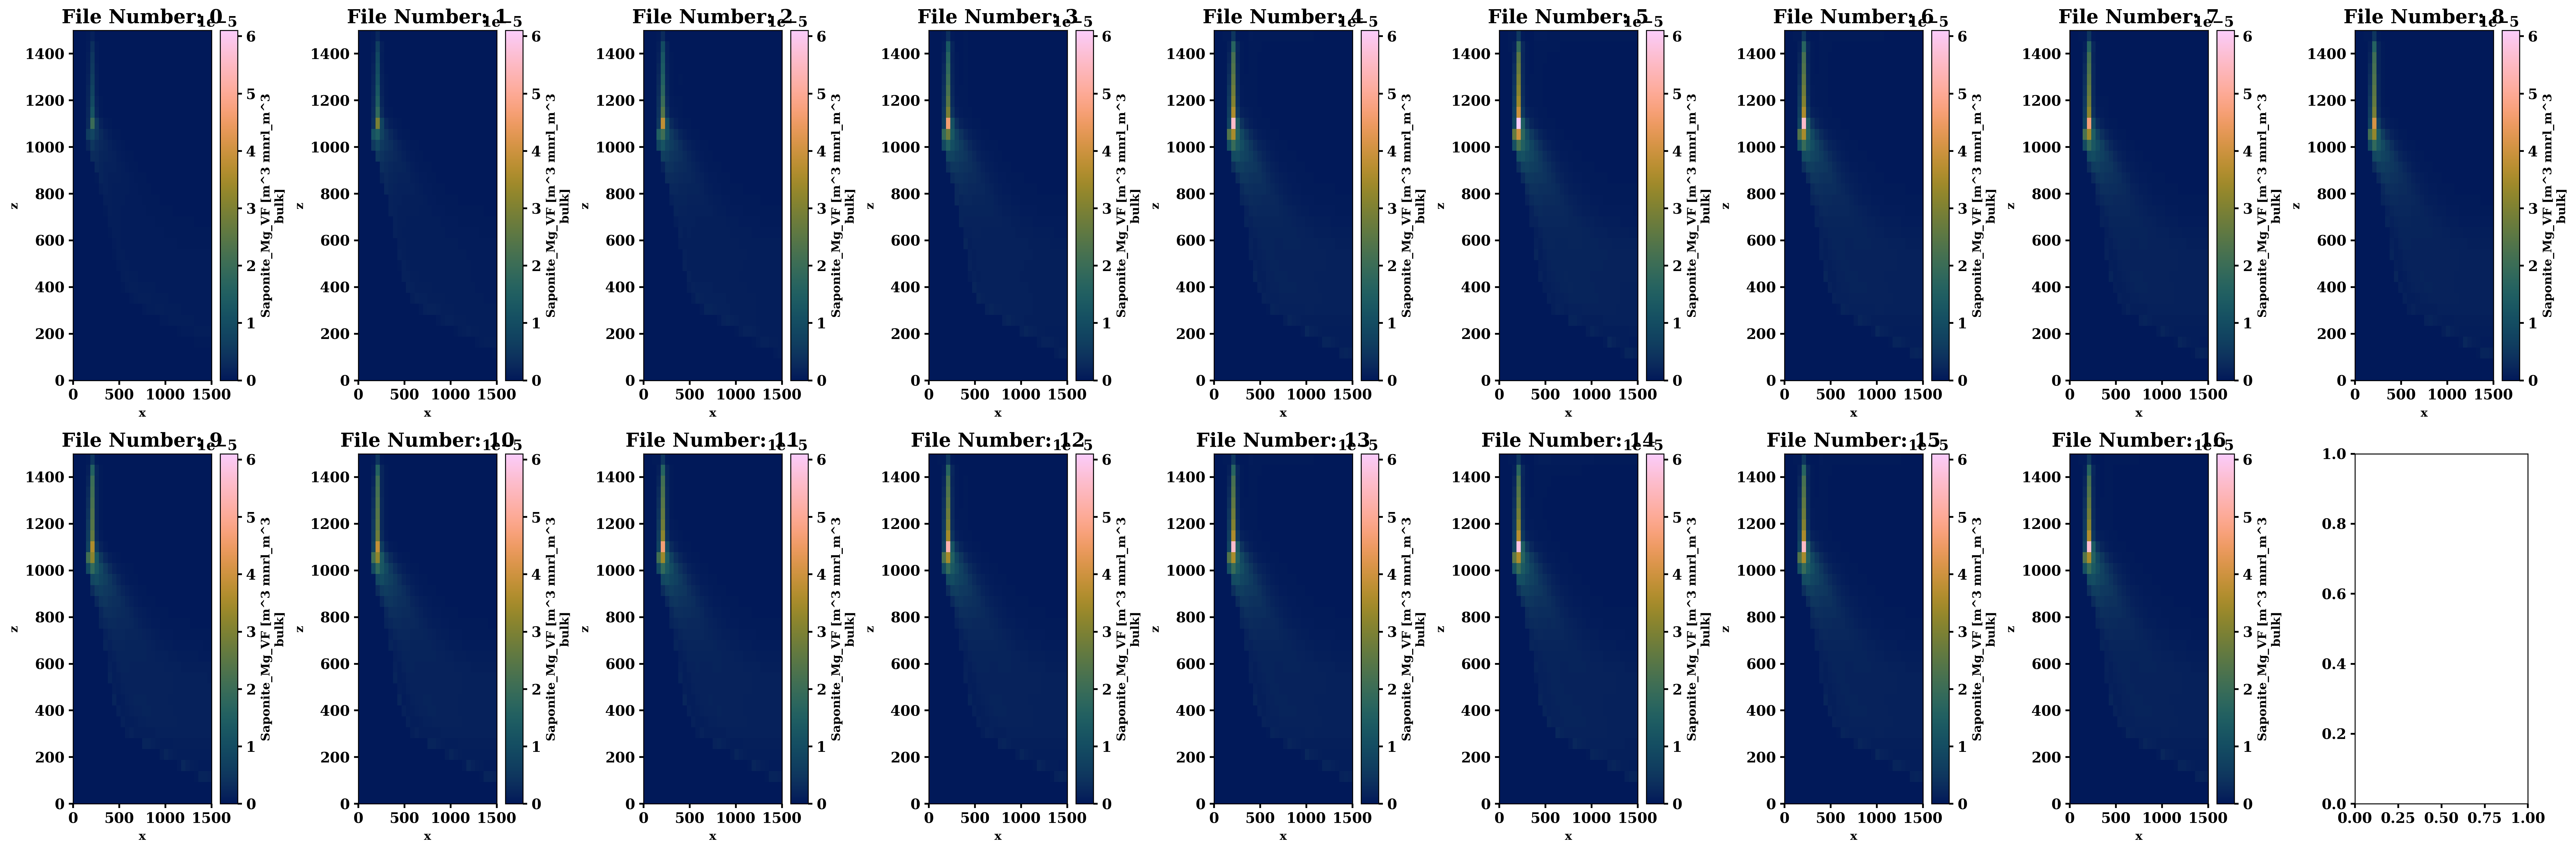

In [10]:
# Code for: <Add description here>
file_numbers = range(17)  # List of file numbers to plot

fig, axes = plt.subplots(2, 9, figsize=(30, 10))  # Create a 2x9 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

plot_var = 'Saponite_Mg_VF'  # Variable to plot
# Determine the global min and max values for the color scale
vmin = pf_data[plot_var].sel(time=1000).min().values
vmax = pf_data[plot_var].sel(time=1000).max().values

for i, file_number in enumerate(file_numbers):
    pf_data.sel(file_number=file_number, time=1000)[plot_var].plot(ax=axes[i], x='x', y='z', vmin=vmin, vmax=vmax, cmap=cm.batlow)
    axes[i].set_title(f'File Number: {file_number}')

plt.tight_layout()
plt.show()